In [56]:
from itertools import product
import numpy as np
import fastplotlib as fpl
import pygfx
import imageio.v3 as iio
from PIL.JpegPresets import presets as qtables
from typing import *

In [7]:
img = iio.imread("imageio:astronaut.png") @ np.asarray([0.299, 0.587, 0.114])

In [8]:
qtables.keys()

dict_keys(['web_low', 'web_medium', 'web_high', 'web_very_high', 'web_maximum', 'low', 'medium', 'high', 'maximum'])

In [9]:
# quantization table for grayscale
qtable_gray = np.asarray(qtables["web_high"]["quantization"][0]).reshape(8, 8)

In [10]:
qtable_gray

array([[ 6,  4,  4,  6,  9, 11, 12, 16],
       [ 4,  5,  5,  6,  8, 10, 12, 12],
       [ 4,  5,  5,  6, 10, 12, 14, 19],
       [ 6,  6,  6, 11, 12, 15, 19, 28],
       [ 9,  8, 10, 12, 16, 20, 27, 31],
       [11, 10, 12, 15, 20, 27, 31, 31],
       [12, 12, 14, 19, 27, 31, 31, 31],
       [16, 12, 19, 28, 31, 31, 31, 31]])

In [11]:
block_size = 8

I, J = np.meshgrid(np.arange(block_size), np.arange(block_size), indexing="ij")

# def generate_basis():
zigzag = np.array(
    [
        [0, 0],
        [0, 1],
        [1, 0],
        [2, 0],
        [1, 1],
        [0, 2],
        [0, 3],
        [1, 2],
        [2, 1],
        [3, 0],
        [4, 0],
        [3, 1],
        [2, 2],
        [1, 3],
        [0, 4],
        [0, 5],
        [1, 4],
        [2, 3],
        [3, 2],
        [4, 1],
        [5, 0],
        [6, 0],
        [5, 1],
        [4, 2],
        [3, 3],
        [2, 4],
        [1, 5],
        [0, 6],
        [0, 7],
        [1, 6],
        [2, 5],
        [3, 4],
        [4, 3],
        [5, 2],
        [6, 1],
        [7, 0],
        [7, 1],
        [6, 2],
        [5, 3],
        [4, 4],
        [3, 5],
        [2, 6],
        [1, 7],
        [2, 7],
        [3, 6],
        [4, 5],
        [5, 4],
        [6, 3],
        [7, 2],
        [7, 3],
        [6, 4],
        [5, 5],
        [4, 6],
        [3, 7],
        [4, 7],
        [5, 6],
        [6, 5],
        [7, 4],
        [7, 5],
        [6, 6],
        [5, 7],
        [6, 7],
        [7, 6],
        [7, 7],
    ]
)

basis = np.zeros((block_size**2, block_size, block_size))
qtable_zigzag = np.zeros(block_size**2)

# u, v is the [i, j] index of the 8x8 block
for i, (u, v) in enumerate(zigzag):
    c = (
        (2 / block_size)
        * np.cos((2 * I + 1) * u * np.pi / (2 * block_size))
        * np.cos((2 * J + 1) * v * np.pi / (2 * block_size))
    )
    c /= np.linalg.norm(c)

    basis[i] = c
    qtable_zigzag[i] = qtable_gray[u, v]

In [12]:
from tqdm import tqdm

In [14]:
iw_basis = fpl.ImageWidget(
    [b for b in basis], 
    histogram_widget=False, 
    cmap="viridis",
    figure_kwargs={"size": (900, 900)},
)
for subplot in iw_basis.figure:
    subplot.toolbar = False
    subplot.axes.visible = False
    
iw_basis.show()

In [15]:
basis.shape

(64, 8, 8)

In [16]:
(64 * 8 * 8) / 4

1024.0

## Projects to DCT space and then unprojects

In [ ]:
# # indices of all 8x8 image blocks
# block_indices = list(product(*(range(np.ceil(dim / block_size).astype(int)) for dim in img.shape)))

# # go through each image block
# for b_i, b_j in tqdm(block_indices):
#     # pixel start and stop indices in this block
#     row_start = b_i * block_size
#     row_stop = row_start + block_size
    
#     col_start = b_j * block_size
#     col_stop = col_start + block_size
#     r_slice, c_slice = slice(row_start, row_stop), slice(col_start, col_stop)

#     # slice 8x8 block from image
#     block = img[r_slice, c_slice]

#     n = 64  # number of basis elements to keep

#     # projection onto the DCT space
#     projection = np.zeros((block_size, block_size))

#     # project the block onto each basis
#     for i in range(n):
#         projection += basis[i] * (basis[i] * block).sum()

#     # image with truncated basis
#     iw.managed_graphics[1].data[r_slice, c_slice] = projection
    
# iw.managed_graphics[1].vmin = 0
# iw.managed_graphics[1].max = 255

## This just projects to DCT space

In [17]:
# indices of all 8x8 image blocks
block_indices = list(product(*(range(np.ceil(dim / block_size).astype(int)) for dim in img.shape)))

img_dct_quantized = np.zeros(img.shape, dtype=np.uint8)

# go through each image block
for b_i, b_j in tqdm(block_indices):
    # pixel start and stop indices in this block
    row_start = b_i * block_size
    row_stop = row_start + block_size
    
    col_start = b_j * block_size
    col_stop = col_start + block_size
    r_slice, c_slice = slice(row_start, row_stop), slice(col_start, col_stop)

    # slice 8x8 block from image
    block = img[r_slice, c_slice]

    n = 64  # number of basis elements to keep

    # projection onto the DCT space
    projection = np.zeros((block_size, block_size), dtype=np.uint8)

    # project the block onto each basis
    for i in range(n):
        p_i, p_j = zigzag[i]
        projection[p_i, p_j] = ((basis[i] * block).sum() / qtable_zigzag[i]).astype(np.uint8)

    # image with truncated basis
    img_dct_quantized[r_slice, c_slice] = projection

100%|█████████████████████████████████████| 4096/4096 [00:02<00:00, 1711.51it/s]


# Generate a RLE for each block (include the DC term for now -- later should use differential encoding for this)

In [58]:
def _rle_single_block(block: np.ndarray,
                      iter_scheme: np.ndarray):

    encoding_list = []
    comparison_value = None
    counter = 0
    for i, (ind0, ind1) in enumerate(iter_scheme):
        
        curr_value = block[ind0, ind1]
        if comparison_value is None:
            comparison_value = curr_value
            counter += 1
        elif comparison_value != curr_value:
            encoding_list.append((comparison_value, counter))
            comparison_value = curr_value
            counter = 1
        else:
            counter += 1
    encoding_list.append((comparison_value, counter))
    return encoding_list

def _decode_single_block_rle(encoding: list,
                             iter_scheme: np.ndarray,
                             block_shape: tuple[int, int],
                            dtype=np.uint8) -> List[Tuple]:
    
    updated_values = np.zeros((block_shape[0], block_shape[1]), dtype=dtype)
    block_counter = 0
    num_remaining = encoding[0][1]
    curr_value = encoding[0][0]
    for i, (ind0, ind1) in enumerate(iter_scheme):
        updated_values[ind0, ind1] = curr_value
        num_remaining -= 1
        if num_remaining == 0 and block_counter != len(encoding) - 1:
            block_counter += 1
            num_remaining = encoding[block_counter][1]
            curr_value = encoding[block_counter][0]
    return updated_values

# slice 8x8 block from image
test_block = img_dct_quantized[0:8, 0:8]
rle_encoding = _rle_single_block(test_block, zigzag)
decoded_rle = _decode_single_block_rle(rle_encoding, 
                                       zigzag,
                                       (8, 8))

print(np.allclose(decoded_rle, test_block))

True


RFBOutputContext()

/data/home/app2139/fastplotlib/fastplotlib/graphics/features/_base.py:18: UserWarning: casting float64 array to float32
  warn(f"casting {array.dtype} array to float32")


JupyterRenderCanvas(css_height='500.0px', css_width='1000.0px')
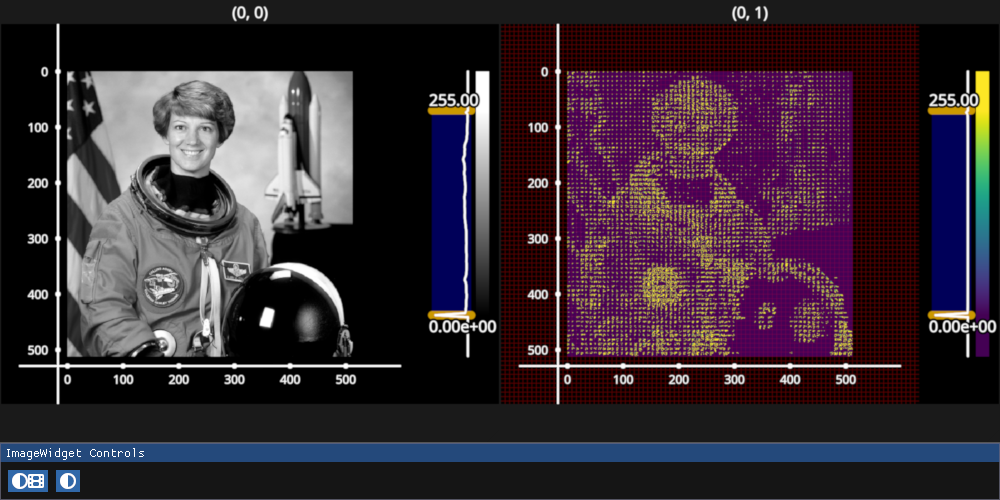

Error during handling pointer_up event
Traceback (most recent call last):
  File "/data/home/app2139/masknmf-toolbox/masknmfvenv/lib/python3.11/site-packages/rendercanvas/_coreutils.py", line 41, in log_exception
    yield
  File "/data/home/app2139/masknmf-toolbox/masknmfvenv/lib/python3.11/site-packages/rendercanvas/_events.py", line 222, in emit
    callback(event)
  File "/data/home/app2139/masknmf-toolbox/masknmfvenv/lib/python3.11/site-packages/wgpu/utils/imgui/imgui_renderer.py", line 183, in _on_mouse
    self._backend.io.add_mouse_button_event(event["button"] - 1, down)
RuntimeError: IM_ASSERT( mouse_button >= 0 && mouse_button < ImGuiMouseButton_COUNT )   ---   imgui.cpp:1698
Error during handling pointer_up event: IM_ASSERT( mouse_button >= 0 … (2)


In [18]:
iw = fpl.ImageWidget(
    [img, img_dct_quantized],
    figure_kwargs={"size": (1000, 500)},
    cmap="gray"
)
iw.managed_graphics[1].vmin = 0
iw.managed_graphics[1].max = 255

grid = pygfx.Grid(
    None, 
    material=pygfx.GridMaterial(
        major_step=(8, 8), major_color="r", major_thickness=0.1, thickness_space='world'
    ), 
    orientation="xy"
)
grid.world.z = 2
grid.world.x = -0.5
grid.world.y = -0.5
iw.figure[0, 1].scene.add(grid)
iw.reset_vmin_vmax_frame()
iw.cmap = ["gray", "viridis"]
for g in iw.managed_graphics:
    g.offset = (0.5, 0.5, 0)

iw.show()